In [1]:
%matplotlib inline

In [86]:
import numpy as np
import lmfit
from scipy.io import readsav
import matplotlib.pyplot as plt

In [11]:
from DSTPolarimeterLib import MuellerMatrixMirror, MuellerMatrixRotation

In [14]:
#--- dtor * deg = rad
dtor = 0.017453292519943295

---

In [62]:
def residual(par, mmHSP, mm_ir, sigma):
    
    mmHSP_model = model(par, mm_ir)
    
    return (mmHSP_model - mmHSP) / sigma

def model(par, mm_ir):
    
    mm_45 = MuellerMatrixMirror(par["mir_delta"].value*dtor, par["mir_p"].value, gen=True)
    mm_45 /= mm_45[0,0]
    
    # depolarization
    mm_45[1,1] -= par["mir_depol"].value
    # QU component
    mm_45[1,2] += par["mir_QU"].value
    mm_45[2,1] += par["mir_QU"].value
    # difference between [0,1] and [1,0]
    mm_45[0,1] += par["mir_pConst"].value
    mm_45[1,0] -= par["mir_pConst"].value
    
    # 以下两行只改变了delta的符号，因为其余符号被反的位置数值上都是0
    mm_45[3,:] = -mm_45[3,:]
    mm_45[:,3] = -mm_45[:,3]
    
    #
    mat = mm_45 @ MuellerMatrixRotation(par["th_dst2mm45"].value*dtor)
    mat = MuellerMatrixRotation(par["th_mm452mmir"].value*dtor) @ mat
    mat = MuellerMatrixRotation(par["th_mmir2hsp"].value*dtor) @ mm_ir @ mat
    
    sc = par["sc"].value
    mat = np.array([
        [1+sc, 0, 0, 0],
        [0   , 1, 0, 0],
        [0   , 0, 1, 0],
        [0   , 0, 0, 1]
    ]) @ mat
    
    mat /= mat[0,0]
    
    return mat

fitted Mueller Matrix of HSP

In [4]:
mmHSP = np.array([
    [1., -0.03454526, -0.02421685, 0.02406610],
    [0.02891437, -0.23698555, -0.95226598, 0.04610067],
    [0.02636235, -0.59941919, 0.14209622, 0.68590858],
    [0.01450438, -0.72102226, 0.12382938, -0.65461389]
], dtype=np.float64)

Mueller Matrix of image rotator

In [107]:
wave = 8600
imgrot = np.deg2rad(-59.462886810302734)
npzFile = np.load("/nwork/kouui/dstsp/data/calibration/save/mmirFilter.npz")
posWave = np.argmin( abs(npzFile["wlFilter"]*10-wave) )  # nm to angstrom
angleArray = np.deg2rad( npzFile["angleArray"] )
posAngle = np.argmin( abs(angleArray-imgrot) )

print("posWave : {}, posAngle : {}".format(posWave, posAngle))

dangle = imgrot - angleArray[posAngle]
mm_ir = MuellerMatrixRotation(dangle) @ npzFile["mmsFilter"][posWave,posAngle,:,:] @ MuellerMatrixRotation(-dangle)

posWave : 812, posAngle : 77


In [108]:
mm_ir

array([[ 1.        ,  0.00882659, -0.02598109, -0.00823799],
       [ 0.02498366,  0.6794385 , -0.16506339, -0.78942546],
       [-0.01289528, -0.1819202 ,  0.96659989, -0.37748578],
       [ 0.00271338,  0.78516071,  0.37225199,  0.55090527]])

In [30]:
del npzFile

Mueller Matrix of mirror

In [15]:
# we try different model for mm_45

fitting parameters

In [68]:
par = lmfit.Parameters()
par.add( "th_dst2mm45", value=0, min=-180, max=180, vary=True)
par.add( "th_mm452mmir", value=90, min=-180, max=180, vary=True)
par.add( "th_mmir2hsp", value=0, min=-180, max=180, vary=True)
par.add( "sc", value=0.0, min=0, max=0.2, vary=True)
par.add( "mir_p", value= -0.0304, min=-1, max=1, vary=True)
par.add( "mir_delta", value=30.447, min=-180, max=180, vary=True)  # deg
par.add( "mir_depol", value=0.0, min=0, max=1, vary=False)
par.add( "mir_QU", value=0.0, min=-0.5, max=0.5, vary=False)
par.add( "mir_pConst", value=0.0, min=-0.2, max=0.2, vary=False)

fitting error

In [90]:
sigma = np.ones((4,4))

start fitting

In [69]:
result = lmfit.minimize(residual, par, args=(mmHSP, mm_ir, sigma),method='leastsq', ftol=1E-12, xtol=1E-12)
lmfit.report_fit(result)

[[Fit Statistics]]
    # function evals   = 143
    # data points      = 16
    # variables        = 6
    chi-square         = 27678.133
    reduced chi-square = 2767.813
    Akaike info crit   = 131.293
    Bayesian info crit = 135.928
[[Variables]]
    th_dst2mm45:    7.21105220 +/- 0        (0.00%) (init= 0)
    th_mm452mmir:   95.2831177 +/- 0        (0.00%) (init= 90)
    th_mmir2hsp:   -39.8977229 +/- 0        (0.00%) (init= 0)
    sc:             0          +/- 0        (nan%) (init= 0)
    mir_p:         -0.02289207 +/- 0        (0.00%) (init=-0.0304)
    mir_delta:      16.6011343 +/- 0        (0.00%) (init= 30.447)
    mir_depol:      0 (fixed)
    mir_QU:         0 (fixed)
    mir_pConst:     0 (fixed)


/home/kouui/virtualenvs/python35/lib/python3.5/site-packages/lmfit/printfuncs.py:140: RuntimeWarning: invalid value encountered in double_scalars
  spercent = '({0:.2%})'.format(abs(par.stderr/par.value))


origin

In [70]:
result.residual.reshape(4,4) * sigma

array([[ 0.        ,  0.00448847, -0.00474118, -0.00934518],
       [-0.00095146,  0.0108648 , -0.07314988, -0.00840923],
       [ 0.01021624, -0.09519374,  0.05202496,  0.08647849],
       [ 0.00430975, -0.0427016 ,  0.02161341, -0.01863115]])

with `depol`

In [53]:
result.residual.reshape(4,4) * sigma

array([[ 0.        ,  0.01598738,  0.01115057, -0.02189748],
       [-0.01174474, -0.03593874, -0.04146636, -0.00955769],
       [-0.002117  , -0.04135916,  0.00539744,  0.090765  ],
       [ 0.00506408,  0.01677387, -0.03305   , -0.02247056]])

with `depol` and `QU`

In [67]:
result.residual.reshape(4,4) * sigma

array([[ 0.        ,  0.01787846,  0.02420255,  0.00117319],
       [-0.03766389, -0.00865181, -0.07173503,  0.00513126],
       [ 0.00404433, -0.02063702,  0.01196712,  0.08476418],
       [-0.00824356,  0.03449218, -0.00021339, -0.0260496 ]])

with `depol`, `QU`, `pConst`

In [61]:
result.residual.reshape(4,4) * sigma

array([[ 0.        ,  0.01040839,  0.02357508,  0.00017655],
       [-0.03324022, -0.01648263, -0.06986656,  0.01187595],
       [ 0.00479372,  0.00021814, -0.00469058,  0.05787638],
       [-0.00849887,  0.00291082,  0.00377151, -0.05119571]])

---

try fitting with free mirror and image rotator

In [264]:
def residual(par, mmHSP):
    
    mmHSP_model = model(par)
    
    return (mmHSP_model - mmHSP)

def model(par):
    
    #--- mm_45
    mm_45 = MuellerMatrixMirror(par["mir_delta"].value*dtor, par["mir_p"].value, gen=True)
    mm_45 /= mm_45[0,0]
    
    # depolarization
    mm_45[1,1] -= par["mir_depol"].value
    # QU component
    mm_45[1,2] += par["mir_QU"].value
    mm_45[2,1] += par["mir_QU"].value
    # UV component
    mm_45[1,3] += par["mir_UV"].value
    mm_45[3,1] += par["mir_UV"].value
    # difference between [0,1] and [1,0]
    mm_45[0,1] += par["mir_pConst"].value
    mm_45[1,0] -= par["mir_pConst"].value
    
    # 以下两行只改变了delta的符号，因为其余符号被反的位置数值上都是0
    mm_45[3,:] = -mm_45[3,:]
    mm_45[:,3] = -mm_45[:,3]
    
    #--- mm_ir
    # mm_ir = np.array([
    #     [1                , par["ir_B"].value      , 0                ,                 0],
    #     [par["ir_B"].value, 1-par["ir_depol"].value, 0                ,                 0],
    #     [0                , 0                      , par["ir_C"].value, par["ir_D"].value],
    #     [0                , 0                      ,-par["ir_D"].value, par["ir_C"].value]
    # ])
    mm_ir = MuellerMatrixMirror(par["ir_delta"].value*dtor, par["ir_p"].value, gen=True)
    mm_ir /= mm_ir[0,0]
    
    # depolarization
    mm_ir[1,1] -= par["ir_depol"].value
    # QU component
    mm_ir[1,2] += par["ir_QU"].value
    mm_ir[2,1] -= par["ir_QU"].value
    # UV component
    mm_ir[1,3] += par["ir_UV"].value
    mm_ir[3,1] -= par["ir_UV"].value
    
    dangle = (-59.4628868-0) * dtor
    mm_ir = MuellerMatrixRotation(dangle) @ mm_ir @ MuellerMatrixRotation(-dangle)
    
    #
    mat = mm_45 @ MuellerMatrixRotation(par["th_dst2mm45"].value*dtor)
    mat = MuellerMatrixRotation(par["th_mm452mmir"].value*dtor) @ mat
    mat = MuellerMatrixRotation(par["th_mmir2hsp"].value*dtor) @ mm_ir @ mat
    
    sc = par["sc"].value
    mat = np.array([
        [1+sc, 0, 0, 0],
        [0   , 1, 0, 0],
        [0   , 0, 1, 0],
        [0   , 0, 0, 1]
    ]) @ mat
    
    mat /= mat[0,0]
    
    return mat

par = lmfit.Parameters()
par.add( "th_dst2mm45", value=-1.4, min=-20, max=20, vary=True)
par.add( "th_mm452mmir", value=89.93, min=70, max=110, vary=True)
par.add( "th_mmir2hsp", value=(88.2 - 131.2), min=(88.2 - 131.2)-20, max=(88.2 - 131.2)+20, vary=True)
par.add( "sc", value=0.0, min=0, max=0.2, vary=True)

par.add( "mir_p", value= -0.0304, min=-0.1, max=0.1, vary=True)
par.add( "mir_delta", value=30.447, min=10, max=50, vary=True)  # deg
par.add( "mir_depol", value=0.0, min=0, max=0.1, vary=False)
par.add( "mir_QU", value=0.0, min=-0.1, max=0.1, vary=True)
par.add( "mir_UV", value=0.0, min=-0.1, max=0.1, vary=True)
par.add( "mir_pConst", value=0.0, min=-0.2, max=0.2, vary=False)


par.add( "ir_p", value= 0.1, min=-0.2, max=0.2, vary=True)
par.add( "ir_delta", value= -120, min=-140, max=-100, vary=True)
par.add( "ir_depol", value=0.0, min=0, max=1, vary=False)
par.add( "ir_QU", value=0.0, min=-0.1, max=0.1, vary=False)
par.add( "ir_UV", value=0.0, min=-0.1, max=0.1, vary=False)

In [265]:
result = lmfit.minimize(residual, par, args=(mmHSP,),method='leastsq', ftol=1E-10, xtol=1E-10)
lmfit.report_fit(result)

[[Fit Statistics]]
    # function evals   = 290
    # data points      = 16
    # variables        = 10
    chi-square         = 0.005
    reduced chi-square = 0.001
    Akaike info crit   = -108.036
    Bayesian info crit = -100.310
[[Variables]]
    th_dst2mm45:   -0.43992803 +/- 0        (0.00%) (init=-1.4)
    th_mm452mmir:   96.9794016 +/- 0        (0.00%) (init= 89.93)
    th_mmir2hsp:   -55.4216284 +/- 0        (0.00%) (init=-43)
    sc:             0          +/- 0        (nan%) (init= 0)
    mir_p:         -0.01140834 +/- 0        (0.00%) (init=-0.0304)
    mir_delta:      50         +/- 0        (0.00%) (init= 30.447)
    mir_depol:      0 (fixed)
    mir_QU:         0.07481150 +/- 0        (0.00%) (init= 0)
    mir_UV:         0.02579932 +/- 0        (0.00%) (init= 0)
    mir_pConst:     0 (fixed)
    ir_p:          -0.03804144 +/- 0        (0.00%) (init= 0.1)
    ir_delta:      -109.140235 +/- 0        (0.00%) (init=-120)
    ir_depol:       0 (fixed)
    ir_QU:          0 

In [266]:
print(result.residual.reshape(4,4))

[[ 0.         -0.00095616  0.00491299 -0.00205342]
 [-0.00142928 -0.00502116 -0.02866979 -0.0098449 ]
 [ 0.01036552 -0.02615006  0.01707319  0.04136372]
 [-0.0066153  -0.02521073 -0.00218629 -0.03003399]]


---

try fitting with experiment result

In [109]:
def residual(par, mmHSP):
    
    mmHSP_model = model(par)
    
    return (mmHSP_model - mmHSP)

def model(par):
    
    #--- mm_45
    mm_45 = np.array([
        [ 1.        , -0.02789666, -0.00278582, -0.01912723],
        [-0.03455996,  0.98631785, -0.09857136, -0.00230055],
        [ 0.00451821, -0.09321724, -0.8493866 , -0.50052879],
        [-0.00378543,  0.01900469,  0.50651627, -0.8551463 ]
    ])

    # 以下两行只改变了delta的符号，因为其余符号被反的位置数值上都是0
    mm_45[3,:] = -mm_45[3,:]
    mm_45[:,3] = -mm_45[:,3]
    
    #--- mm_ir
    mm_ir = np.array([
        [ 1.        ,  0.00882659, -0.02598109, -0.00823799],
        [ 0.02498366,  0.6794385 , -0.16506339, -0.78942546],
        [-0.01289528, -0.1819202 ,  0.96659989, -0.37748578],
        [ 0.00271338,  0.78516071,  0.37225199,  0.55090527]
    ])
    
    #
    mat = mm_45 @ MuellerMatrixRotation(par["th_dst2mm45"].value*dtor)
    mat = MuellerMatrixRotation(par["th_mm452mmir"].value*dtor) @ mat
    mat = MuellerMatrixRotation(par["th_mmir2hsp"].value*dtor) @ mm_ir @ mat
    
    sc = par["sc"].value
    mat = np.array([
        [1+sc, 0, 0, 0],
        [0   , 1, 0, 0],
        [0   , 0, 1, 0],
        [0   , 0, 0, 1]
    ]) @ mat
    
    mat /= mat[0,0]
    
    return mat

par = lmfit.Parameters()
par.add( "th_dst2mm45", value=0, min=-180, max=180, vary=True)
par.add( "th_mm452mmir", value=90, min=-180, max=180, vary=True)
par.add( "th_mmir2hsp", value=0, min=-180, max=180, vary=True)
par.add( "sc", value=0.0, min=0, max=0.2, vary=True)

In [110]:
result = lmfit.minimize(residual, par, args=(mmHSP,),method='leastsq', ftol=1E-12, xtol=1E-12)
lmfit.report_fit(result)

[[Fit Statistics]]
    # function evals   = 53
    # data points      = 16
    # variables        = 4
    chi-square         = 0.028
    reduced chi-square = 0.002
    Akaike info crit   = -93.386
    Bayesian info crit = -90.295
[[Variables]]
    th_dst2mm45:   -1.40194677 +/- 0        (0.00%) (init= 0)
    th_mm452mmir:   89.9317740 +/- 0        (0.00%) (init= 90)
    th_mmir2hsp:   -49.5118590 +/- 0        (0.00%) (init= 0)
    sc:             0          +/- 0        (nan%) (init= 0)


In [111]:
result.residual.reshape(4,4)

array([[ 0.        , -0.00517181,  0.00631102,  0.01508518],
       [-0.01157695,  0.0205107 , -0.0715675 , -0.00585125],
       [ 0.0231681 , -0.09717611,  0.05722874,  0.08709529],
       [ 0.01577485, -0.02356922,  0.02575757, -0.00337743]])

---

iterative fitting

In [128]:
def residual(par, mmHSP):
    
    mmHSP_model = model(par)
    
    return (mmHSP_model - mmHSP)

def model(par):
    
    #--- mm_45
    mm_45 = np.ones((4,4))
    for i in range(4):
        for j in range(4):
            mm_45[i,j] = par["mir_{}{}".format(i,j)].value
    
    #--- mm_ir
    mm_ir = np.ones((4,4))
    for i in range(4):
        for j in range(4):
            mm_ir[i,j] = par["ir_{}{}".format(i,j)].value

    #
    mat = mm_45 @ MuellerMatrixRotation(par["th_dst2mm45"].value*dtor)
    mat = MuellerMatrixRotation(par["th_mm452mmir"].value*dtor) @ mat
    mat = MuellerMatrixRotation(par["th_mmir2hsp"].value*dtor) @ mm_ir @ mat
    
    sc = par["sc"].value
    mat = np.array([
        [1+sc, 0, 0, 0],
        [0   , 1, 0, 0],
        [0   , 0, 1, 0],
        [0   , 0, 0, 1]
    ]) @ mat
    
    mat /= mat[0,0]
    
    return mat

mm_45 = np.array([
        [ 1.        , -0.02789666, -0.00278582 , 0.01912723],
        [-0.03455996,  0.98631785, -0.09857136 , 0.00230055],
        [ 0.00451821, -0.09321724, -0.8493866  , 0.50052879],
        [0.00378543,  -0.01900469,  -0.50651627, -0.8551463 ]
    ])
mm_ir = np.array([
        [ 1.        ,  0.00882659, -0.02598109, -0.00823799],
        [ 0.02498366,  0.6794385 , -0.16506339, -0.78942546],
        [-0.01289528, -0.1819202 ,  0.96659989, -0.37748578],
        [ 0.00271338,  0.78516071,  0.37225199,  0.55090527]
    ])

par = lmfit.Parameters()
par.add( "th_dst2mm45", value=0, min=-180, max=180, vary=True)
par.add( "th_mm452mmir", value=90, min=-180, max=180, vary=True)
par.add( "th_mmir2hsp", value=0, min=-180, max=180, vary=True)
par.add( "sc", value=0.0, min=0, max=0.2, vary=False)
for i in range(4):
    for j in range(4):
        par.add( "mir_{}{}".format(i,j), value=mm_45[i,j], min=-1, max=1, vary=False)
for i in range(4):
    for j in range(4):
        par.add(  "ir_{}{}".format(i,j), value=mm_ir[i,j], min=-1, max=1, vary=False)

In [129]:
tol = 1E-7
for it in range(5):
    
    #--- fit angle
    if it==0:
        result1 = lmfit.minimize(residual, par, args=(mmHSP,),method='leastsq', ftol=tol, xtol=tol)
    else :
        for key in result2.params.keys():
            par[key].set(value=result2.params[key].value)
        for i in range(4):
            for j in range(4):
                par["ir_{}{}".format(i,j)].set(vary=False)
                #par["mir_{}{}".format(i,j)].set(vary=False)
        for parname in ("th_dst2mm45","th_mm452mmir","th_mmir2hsp"):
            par[parname].set(vary=True)
        result1 = lmfit.minimize(residual, par, args=(mmHSP,),method='leastsq', ftol=tol, xtol=tol)
        
    #--- fit image rotator
    for key in result1.params.keys():
        par[key].set(value=result1.params[key].value)
    for i in range(4):
        for j in range(4):
            if i==0 and j==0 :
                continue
            par["ir_{}{}".format(i,j)].set(vary=True)
    for parname in ("th_dst2mm45","th_mm452mmir","th_mmir2hsp"):
        par[parname].set(vary=False)
    
    result2 = lmfit.minimize(residual, par, args=(mmHSP,),method='leastsq', ftol=tol, xtol=tol)

lmfit.report_fit(result2)

[[Fit Statistics]]
    # function evals   = 19
    # data points      = 16
    # variables        = 15
    chi-square         = 0.000
    reduced chi-square = 0.000
    Akaike info crit   = -1169.654
    Bayesian info crit = -1158.066
[[Variables]]
    th_dst2mm45:   -1.401913 (fixed)
    th_mm452mmir:   89.93181 (fixed)
    th_mmir2hsp:   -49.51181 (fixed)
    sc:             0 (fixed)
    mir_00:         1 (fixed)
    mir_01:        -0.02789666 (fixed)
    mir_02:        -0.00278582 (fixed)
    mir_03:         0.01912723 (fixed)
    mir_10:        -0.03455996 (fixed)
    mir_11:         0.9863179 (fixed)
    mir_12:        -0.09857136 (fixed)
    mir_13:         0.00230055 (fixed)
    mir_20:         0.00451821 (fixed)
    mir_21:        -0.09321724 (fixed)
    mir_22:        -0.8493866 (fixed)
    mir_23:         0.5005288 (fixed)
    mir_30:         0.00378543 (fixed)
    mir_31:        -0.01900469 (fixed)
    mir_32:        -0.5065163 (fixed)
    mir_33:        -0.8551463 (fixed)


fitted `mm_ir` is 

$$
\begin{bmatrix}
+1.0000 & +0.0032 & -0.0230 & +0.0077 \\
+0.0035 & +0.5741 & -0.1664 & -0.6873 \\
-0.0206 & -0.1955 & +0.9099 & -0.3537 \\
-0.0123 & +0.7583 & +0.3511 & +0.5589
\end{bmatrix}
$$

original `mm_ir` is 

$$
\begin{bmatrix}
+1.0000 & +0.0088 & -0.0260 & -0.0082 \\
+0.0250 & +0.6794 & -0.1651 & -0.7894 \\
-0.0129 & -0.1819 & +0.9666 & -0.3775 \\
+0.0027 & +0.7852 & +0.3723 & +0.5509
\end{bmatrix}
$$

error matrix is 

$$
\begin{bmatrix}
+0.0000 & -0.0056 & +0.0030 & +0.0159 \\
-0.0215 & -0.1053 & -0.0013 & +0.1021 \\
-0.0077 & -0.0136 & -0.0567 & +0.0238 \\
-0.0150 & -0.0269 & -0.0212 & +0.0080
\end{bmatrix}
$$

In [131]:
mm_ir_fitted = np.ones((4,4))
for i in range(4):
    for j in range(4):
        mm_ir_fitted[i,j] = result2.params["ir_{}{}".format(i,j)].value

mm_ir_origin = np.array([
        [ 1.        ,  0.00882659, -0.02598109, -0.00823799],
        [ 0.02498366,  0.6794385 , -0.16506339, -0.78942546],
        [-0.01289528, -0.1819202 ,  0.96659989, -0.37748578],
        [ 0.00271338,  0.78516071,  0.37225199,  0.55090527]
    ])

mm_ir_error = mm_ir_fitted - mm_ir_origin

In [130]:
print(result2.residual.reshape(4,4))

[[  0.00000000e+00  -5.55111512e-17   5.20417043e-17  -2.77555756e-17]
 [  5.89805982e-17   5.55111512e-17   0.00000000e+00  -2.08166817e-17]
 [ -6.93889390e-17   0.00000000e+00  -2.77555756e-17  -1.11022302e-16]
 [  1.73472348e-18   0.00000000e+00   1.11022302e-16   0.00000000e+00]]


---

fit mm_ir

In [333]:
def residual(par, mm_ir_fitted):
    
    mm_ir = model(par)
    
    return (mm_ir - mm_ir_fitted)

def model(par):
    
    mm_ir = MuellerMatrixMirror(par["ir_delta"].value*dtor, par["ir_p"].value, gen=True)
    mm_ir /= mm_ir[0,0]
    
    # depolarization
    mm_ir[1,1] -= par["ir_depolP"].value
    mm_ir[2,2] -= par["ir_depolU"].value
    mm_ir[3,3] -= par["ir_depolV"].value
    # QU component
    mm_ir[1,2] += par["ir_QU"].value
    mm_ir[2,1] -= par["ir_QU"].value
    mm_ir[1,2] = par["ir_12"].value
    mm_ir[2,1] = par["ir_21"].value
    # UV component
    mm_ir[1,3] += par["ir_UV"].value
    mm_ir[3,1] -= par["ir_UV"].value
    mm_ir[1,3] = par["ir_13"].value
    mm_ir[3,1] = par["ir_31"].value
    # IU compunent
    mm_ir[0,2] = par["ir_02"].value
    mm_ir[2,0] = par["ir_20"].value
    # Retardation Constant
    mm_ir[2,3] += par["ir_retardC"].value
    mm_ir[3,2] += par["ir_retardC"].value
    # p constant
    mm_ir[0,1] += par["ir_pC"].value
    mm_ir[0,1] -= par["ir_pC"].value
    # [0,3], [3,0]
    # mm_ir[0,3] = 0.00766654
    # mm_ir[3,0] = -0.01226272
    
    dangle = par["dangle"].value * dtor
    mm_ir = MuellerMatrixRotation(dangle) @ mm_ir @ MuellerMatrixRotation(-dangle)

    
    return mm_ir

par = lmfit.Parameters()
par.add( "dangle", value=(-59.4628868-0), min=-100, max=20, vary=True)
par.add( "ir_p", value= 0.1, min=-0.2, max=0.2, vary=True)
par.add( "ir_delta", value= -120, min=-140, max=-100, vary=True)
par.add( "ir_depolP", value=0.00, min=-0.2, max=0.2, vary=True)
par.add( "ir_depolU", value=0.00, min=-0.2, max=0.2, vary=True)
par.add( "ir_depolV", value=0.00, min=-0.2, max=0.2, vary=True)

par.add( "ir_QU", value=0.0, min=-0.2, max=0.2, vary=False)
par.add( "ir_UV", value=0.0, min=-0.2, max=0.2, vary=False)

par.add( "ir_02", value=0.0, min=-0.2, max=0.2, vary=False)
par.add( "ir_20", value=0.0, min=-0.2, max=0.2, vary=False)
par.add( "ir_12", value=0.0, min=-0.2, max=0.2, vary=True)
par.add( "ir_21", value=0.0, min=-0.2, max=0.2, vary=True)
par.add( "ir_13", value=0.0, min=-0.2, max=0.2, vary=False)
par.add( "ir_31", value=0.0, min=-0.2, max=0.2, vary=False)

par.add( "ir_retardC", value=0, min=-0.2, max=0.2, vary=True)
par.add( "ir_pC", value=0, min=-0.1, max=0.1, vary=False)


result = lmfit.minimize(residual, par, args=(mm_ir_fitted,),method='leastsq', ftol=1E-18, xtol=1E-18)
print("origin: ")
print(mm_ir_fitted)
print("residual : ")
print(result.residual.reshape(4,4))
lmfit.report_fit(result)

origin: 
[[ 1.          0.00324011 -0.02298415  0.00766654]
 [ 0.00352479  0.57406001 -0.16625477 -0.68725705]
 [-0.02056619 -0.19548498  0.90986783 -0.35368097]
 [-0.01226272  0.75822459  0.35109523  0.55892505]]
residual : 
[[  0.00000000e+00   5.97093319e-03   4.04348311e-03  -7.66653538e-03]
 [  5.68624635e-03  -6.66133815e-16  -8.32667268e-17  -7.65388889e-03]
 [  1.62552214e-03  -3.60822483e-16   4.44089210e-16   1.57386959e-02]
 [  1.22627216e-02  -6.93661634e-03   1.42637677e-02  -1.11022302e-16]]
[[Fit Statistics]]
    # function evals   = 72
    # data points      = 16
    # variables        = 9
    chi-square         = 0.001
    reduced chi-square = 0.000
    Akaike info crit   = -139.411
    Bayesian info crit = -132.458
[[Variables]]
    dangle:      -57.9670636 +/- 0.277959 (0.48%) (init=-59.46289)
    ir_p:        -0.02106162 +/- 0.007810 (37.08%) (init= 0.1)
    ir_delta:    -126.462123 +/- 0.753257 (0.60%) (init=-120)
    ir_depolP:    0.01208917 +/- 0.011052 (91.42%) 

---

error created by rotating $2^\circ$ from $-57.9^\circ$

In [71]:
npzFile = np.load("/nwork/kouui/dstsp/data/calibration/save/mmirFilter.npz")

In [78]:
angleArray = np.deg2rad( npzFile["angleArray"] )
posAngle = np.argmin( abs(angleArray-imgrot) )
print("we want to calculate Mueller Matrix of image rotator at angle: ",imgrot/dtor)
print("reference ratation angle: {} deg".format(angleArray[posAngle]/dtor))

we want to calculate Mueller Matrix of image rotator at angle:  -59.4628868103
reference ratation angle: -57.9 deg


In [79]:
angleArray[posAngle-1]/dtor

-56.0

In [80]:
npzFile["mmsFilter"].shape

(1400, 104, 4, 4)

In [81]:
# reference matrix
mmir_m579 = npzFile["mmsFilter"][:,posAngle,:,:]
# target matrix
mmir_m560 = npzFile["mmsFilter"][:,posAngle-1,:,:]

In [82]:
dangle = (-56.0+57.9) * dtor # target-reference

In [83]:
mmir_diff = MuellerMatrixRotation(dangle) @ mmir_m579 @ MuellerMatrixRotation(-dangle) - mmir_m560

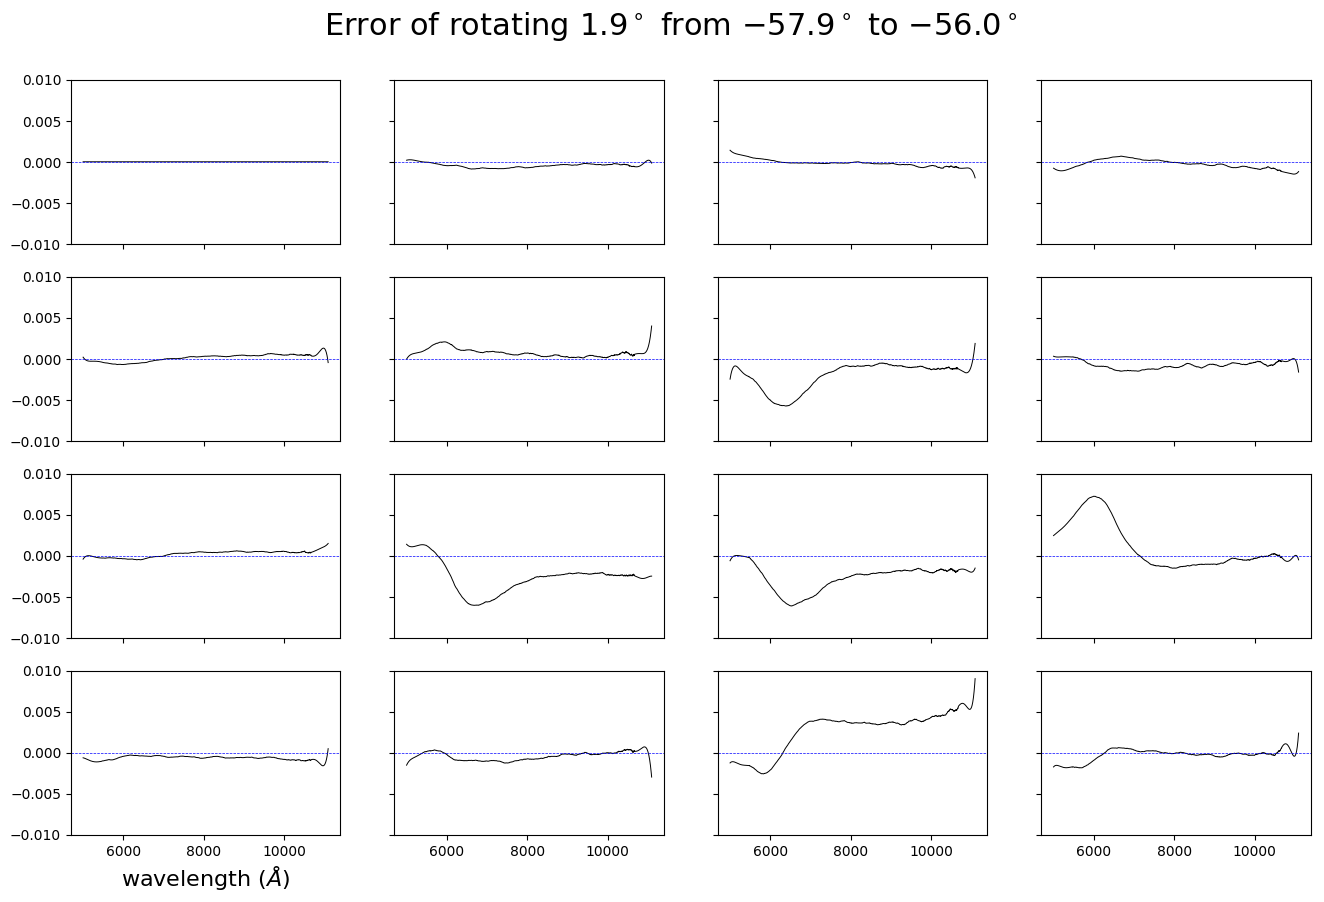

In [89]:
#
fig, axs = plt.subplots(4,4, figsize=(16,10), dpi=100, sharex=True, sharey=True)

for i in range(4):
    for j in range(4):
        ax = axs[i,j]
        ax.plot(npzFile["wlFilter"]*10, mmir_diff[:,i,j], '-k', linewidth=0.7)
        ax.set_ylim(-0.01,0.01)
        ax.axhline(y=0, linestyle='--', linewidth=0.5, color='b')

axs[-1,0].set_xlabel('wavelength ($\AA$)', fontsize=16)
fig.suptitle('Error of rotating $1.9^\circ$ from $-57.9^\circ$ to $-56.0^\circ$', x=0.5, y=0.95, fontsize=22);